In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import utils_img_rec as ut

import pathlib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import layers, models, utils

import pickle
inicio = time.time()

## Definindo Variaveis

In [2]:
BATCH_SIZE = 5000
EPOCHS = 3
IMG_SIZE = 2
numero_de_canais = 3
teste_treino = True

DATA_DIR = '../bases/pickle/imagens/cifar10/cifar10-train-3-2x2-pickle.pickle'

TEST_DIR = '../bases/pickle/imagens/cifar10/cifar10-test-3-2x2-pickle.pickle'

caminho_modelo = '../modelos_salvos/tensorflow'
nome = 'modelo_cifar10'

DATA_DIR = pathlib.Path(DATA_DIR)
TEST_DIR = pathlib.Path(TEST_DIR)

## Lendo e preparando os dados

In [3]:
pickle_in = open(DATA_DIR,"rb")
data_train = pickle.load(pickle_in)

In [4]:
if teste_treino:
    pickle_in = open(TEST_DIR,"rb")
    data_test = pickle.load(pickle_in)

In [5]:
CATEGORIES = ut.get_classes(data_train)
CATEGORIES.sort()
try:
    CATEGORIES.remove('.ipynb_checkpoints')
except:
    pass
print(CATEGORIES)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
train_X, train_y = ut.prep_data(data_train, CATEGORIES, IMG_SIZE, numero_de_canais)
#print("Number of training images: ",len(data_train))
print('Entradas de treino - {} - ({}x{})'.format( train_X.shape[0], train_X.shape[1], train_X.shape[2] ))

Shape dos dados:  (30, 2, 2, 3)
Entradas de treino - 30 - (2x2)


## Exibindo amostra dos dados de treino

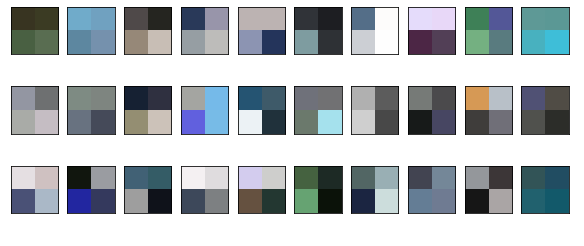

In [7]:
plt.figure(figsize=(10,10))
m = 70
if( len(data_train) < 70 ):
    m = len(data_train)
for i in range(m):
    plt.subplot(7,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_train[i][0], cmap='gray')
    plt.xlabel("{}\n({})".format( data_train[i][1] , data_train[i][2] ), color='white')    
plt.show()

In [8]:
if teste_treino:
    test_X, test_y = ut.prep_data(data_test, CATEGORIES, IMG_SIZE, numero_de_canais)
    #print("Number of test images: ",len(data_test))
    print('Entradas de teste - {} - ({}x{})'.format( test_X.shape[0], test_X.shape[1], test_X.shape[2] ))

Shape dos dados:  (30, 2, 2, 3)
Entradas de teste - 30 - (2x2)


## Exibindo amostra dos dados de teste

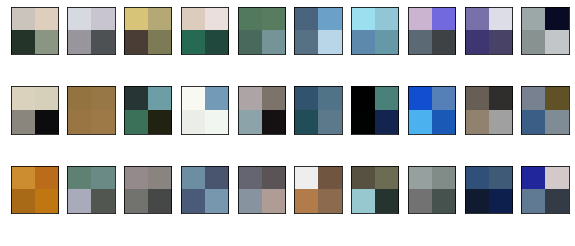

In [9]:
plt.figure(figsize=(10,10))
m = 70
if( len(data_test) < 70 ):
    m = len(data_test)
for i in range(m):
    plt.subplot(7,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_test[i][0], cmap='gray')
    plt.xlabel("{}\n({})".format( data_test[i][1] , data_test[i][2] ), color='white')    
plt.show()

## Normalizando dados

In [10]:
train_X=np.array(train_X/255.0)
train_y=np.array(train_y)
if teste_treino:
    test_X=np.array(test_X/255.0)
    test_y=np.array(test_y)

## Modelo

In [11]:
model = models.Sequential()
model.add( layers.Conv2D(filters=64, kernel_size=(1, 1), activation='relu', input_shape=(test_X.shape[1:])))
#model.add( layers.MaxPooling2D((2, 2)))

#model.add( layers.Dropout(rate=0.2) )

#model.add( layers.Conv2D(filters=128, kernel_size=(8, 8), activation='relu'))
#model.add( layers.MaxPooling2D((2, 2)))

#model.add( layers.Dropout(rate=0.25) )

#model.add( layers.Conv2D(filters=32, kernel_size=(2, 2), activation='relu'))
#model.add( layers.MaxPooling2D((2, 2)))

#model.add( layers.Dropout(rate=0.2) )

model.add( layers.Flatten( ) )
#model.add( layers.Dense(60000, activation='relu') )
#model.add( layers.Dropout(rate=0.4) )

model.add( layers.Dense(1100, activation='relu') )
model.add( layers.Dropout(rate=0.1) )

model.add( layers.Dense(128, activation='relu') )
model.add( layers.Dense(len(CATEGORIES) , activation='softmax') )

## Realizando o treino

In [12]:
#opt = tf.keras.optimizers.SGD(
#    learning_rate=0.01, momentum=0.1, nesterov=False, name="SGD")
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
if  teste_treino:
    history = model.fit(train_X, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_X, test_y))
else:
    history = model.fit(train_X, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

Epoch 1/3
1/1 [==============================] - 1s 554ms/step - loss: 2.3075 - accuracy: 0.1333 - val_loss: 2.2985 - val_accuracy: 0.0667
Epoch 2/3
1/1 [==============================] - 0s 35ms/step - loss: 2.2708 - accuracy: 0.2000 - val_loss: 2.2957 - val_accuracy: 0.1667
Epoch 3/3
1/1 [==============================] - 0s 31ms/step - loss: 2.2331 - accuracy: 0.3000 - val_loss: 2.2917 - val_accuracy: 0.1333


## Grafico do treino

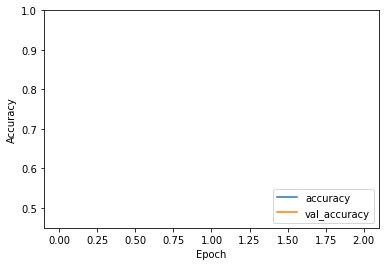

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.45, 1])
plt.legend(loc='lower right')

In [14]:
test_loss, test_acc = model.evaluate(test_X, test_y, verbose=1)

nome_saida = caminho_modelo+nome+' - val_acc = '+   str(round(test_acc, 6))  +'.h5'
#nome_saida = caminho_modelo+nome+'.h5'

#model.save(nome_saida)
#print('Salvo como: ',nome_saida)

1/1 [==============================] - 0s 16ms/step - loss: 2.2917 - accuracy: 0.1333


In [15]:
print('Tempo de execução: ', time.time() - inicio)

Tempo de execução:  3.772434949874878
